In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surmise.emulation import emulator
import dill as pickle
from sklearn.metrics import explained_variance_score

import model

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
epsilon = 0.01
ntrain = 700
fat_frac = 0.3

fat_id = f'fat_{fat_frac:.1f}'
emu_id = f'eps_{epsilon:.4e}_ntrain_{ntrain}' + '_' + fat_id


design_points = np.load('datfiles/' + fat_id + '_posterior_samples.npy')
input_points = np.load('datfiles/' + fat_id + '_posterior_chain.npy')

with open('emulators/emu_' + emu_id + '.pkl', 'rb') as f:
    emu = pickle.load(f)

nrpar = 16
ntest = design_points.shape[0] - ntrain

In [3]:
emu._info['pc'].shape

(700, 100)

In [4]:
f = design_points[:ntrain, :]
w = input_points[:ntrain, :nrpar]
p = emu.predict(x=model.x)

fp = design_points[ntrain:, :]
wp = input_points[ntrain:, :nrpar]

pp = emu.predict(x=model.x, theta=wp)

In [5]:
f.shape, p.mean().T.shape

((700, 573), (700, 573))

In [6]:
fp.shape, pp.mean().T.shape

((300, 573), (300, 573))

(573,)
19


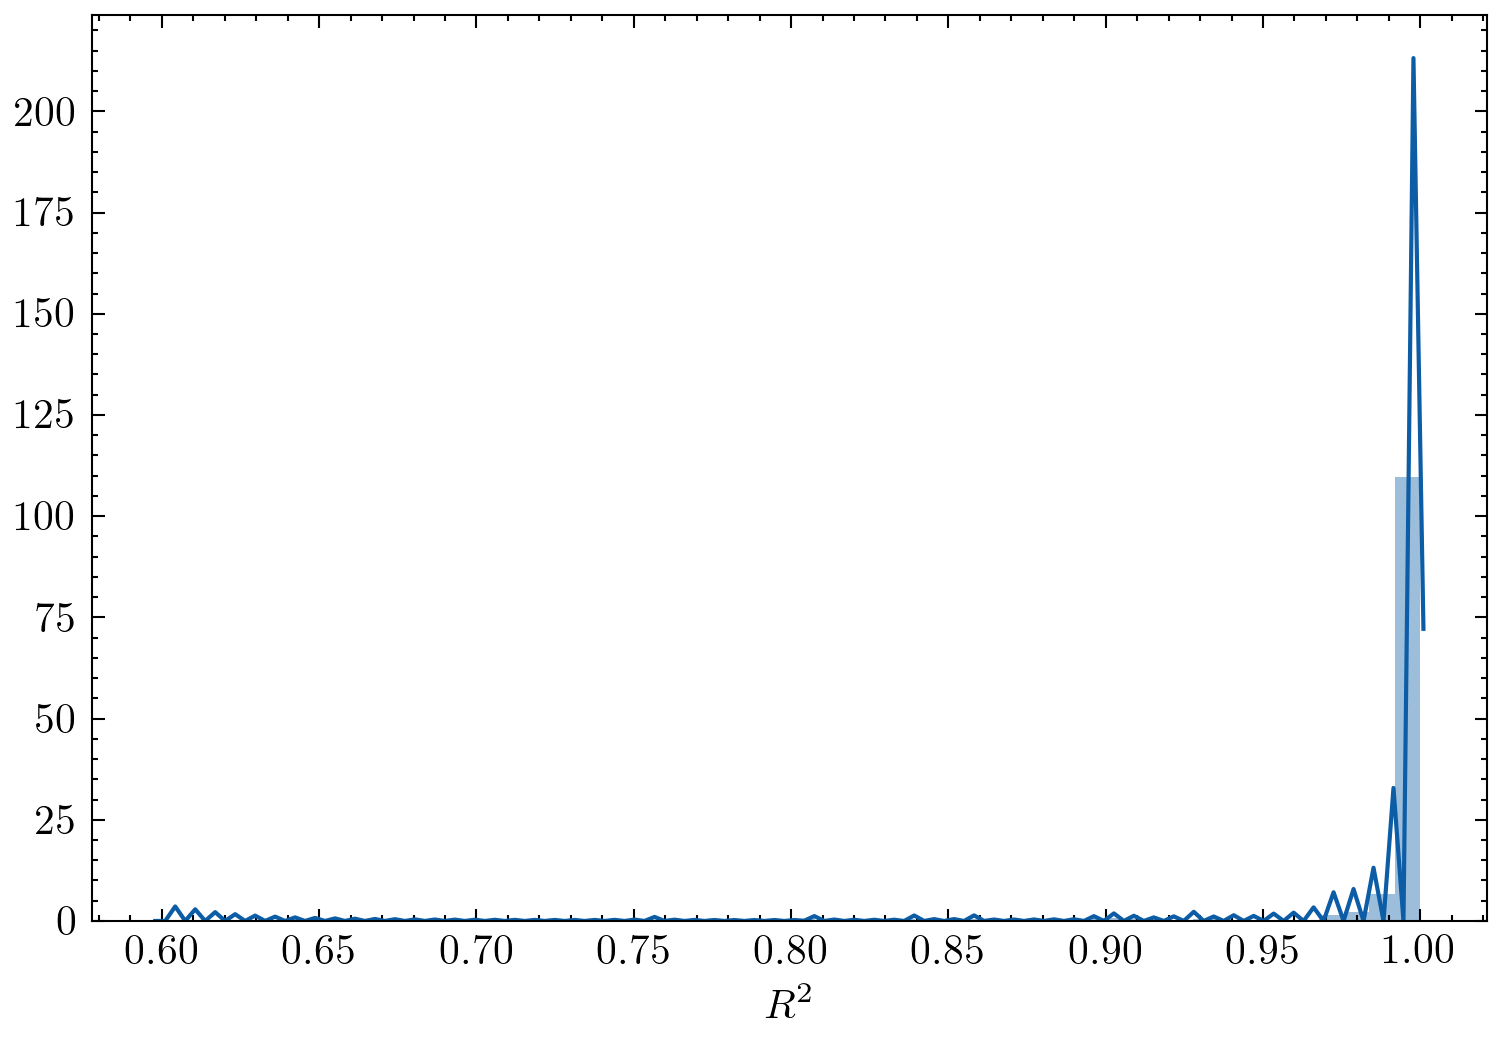

In [22]:
R2 = np.array([explained_variance_score(y, mu) for (y, mu) in zip(f.T, p.mean())])
print(R2.shape)

fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

sns.distplot(R2, ax=ax)

ax.set_xlabel('$R^2$')

print(np.where(R2 < 0.95)[0].size)

In [23]:
ii = np.where(R2 < 0.95)[0]
print(ii.shape, R2.shape)
R2x = np.array([(y-mu)/y for (y, mu) in zip(f.T[ii, :], p.mean()[ii, :])])
print(R2x.shape)

(19,) (573,)
(19, 700)


((20,), (700, 19))

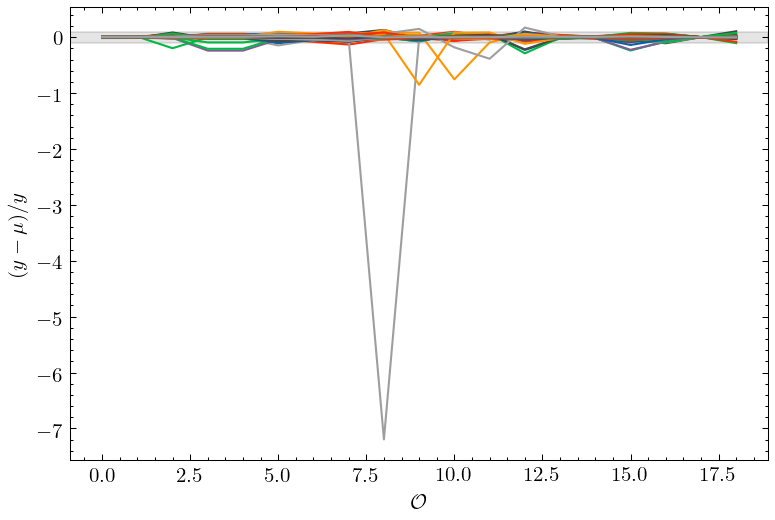

In [30]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

for row in R2x.T:
    ax.plot(row)

max_res = 0.1
ax.axhspan(-max_res, max_res, color='k', alpha=0.1)
ax.set_xlabel(r'$\mathcal{O}$')
ax.set_ylabel(r'$(y-\mu)/y$')

jj = np.where(np.max(np.abs(R2x.T), axis=1) > max_res)[0]
jj.shape, R2x.T.shape

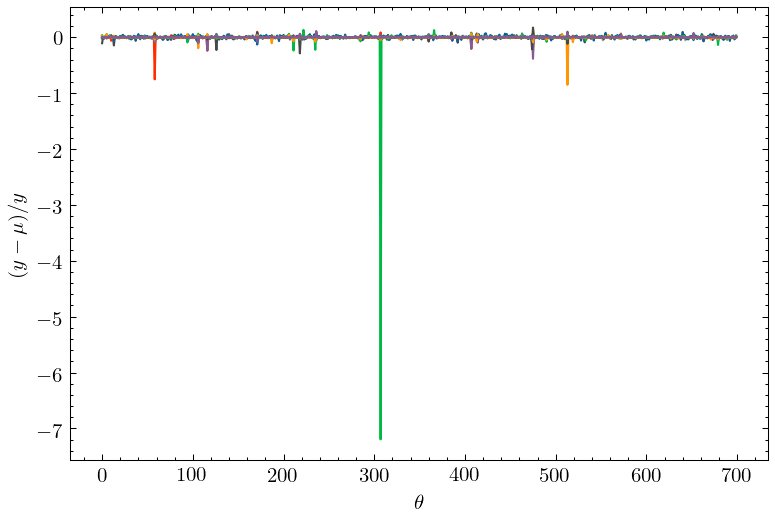

In [25]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

for row in R2x:
    ax.plot(row)
    
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$(y-\mu)/y$');

In [32]:
np.max(np.abs(R2x), axis=0).shape

(700,)

In [33]:
good_points_indices = np.where(np.max(np.abs(R2x), axis=0) < 0.1)[0]

In [34]:
good_points_indices.shape

(680,)

In [35]:
f_good = f[good_points_indices, :]
w_good = w[good_points_indices, :]

In [36]:
f_good.shape

(680, 573)

In [37]:
emu_good = emulator(x=model.x, theta=w_good, f=f_good.T, method='PCGPwM',
                    args={'epsilon' : epsilon, 'warnings' : True})

PCGPwM considering  92 PCs


In [38]:
with open('emulators/emu_good_' + emu_id + f'_cutoff_0.10.pkl', 'wb') as o:
    pickle.dump(emu_good, o, pickle.HIGHEST_PROTOCOL)

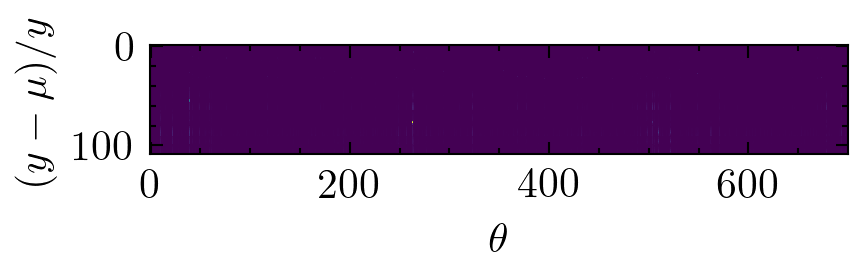

In [19]:
fig, ax = plt.subplots(figsize=(h, h), dpi=300)
fig.patch.set_facecolor('white')

ax.imshow(np.abs(R2x))

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$(y-\mu)/y$');
plt.savefig('difficult_observables_vs_training_points.pdf');

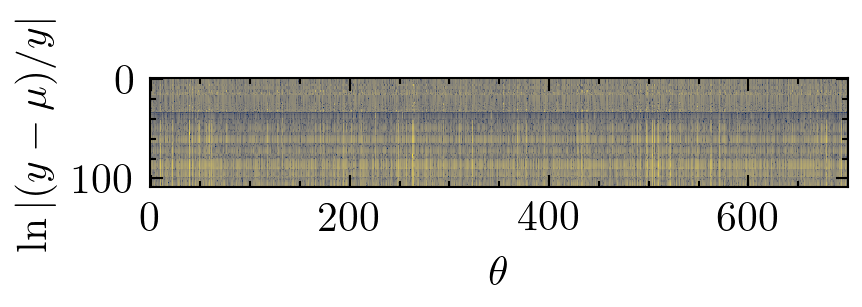

In [18]:
fig, ax = plt.subplots(figsize=(h, h), dpi=300)
fig.patch.set_facecolor('white')

ax.imshow(np.log(np.abs(R2x)), cmap='cividis')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\ln{\lvert (y-\mu)/y\rvert} $');
plt.savefig('difficult_observables_vs_training_points.pdf');

7


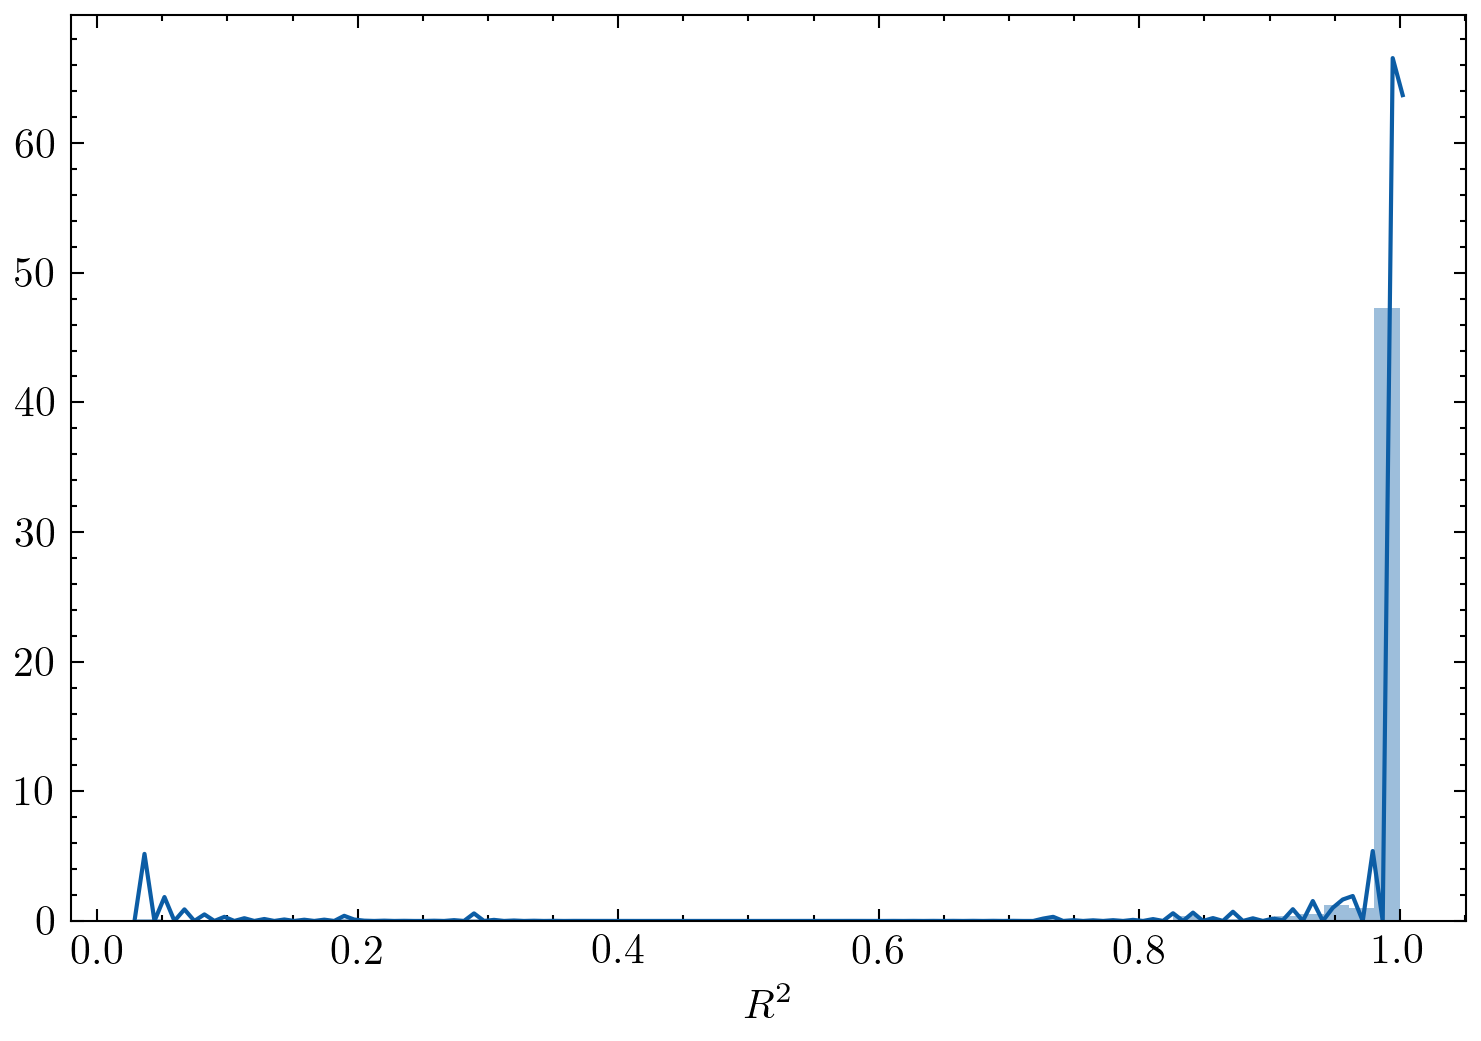

In [19]:
R2 = np.array([explained_variance_score(y, mu) for (y, mu) in zip(fp, pp.mean().T)])

fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

sns.distplot(R2, ax=ax)

ax.set_xlabel('$R^2$')

print(np.where(R2 < 0.9)[0].size)